In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import scipy as stats

In [6]:
from fbprophet import Prophet

## The Data
     Transactions at advertised locations for the last 2 years, by Day & Week. This data will be used to forecast out weekly Transactions to compare last year to.

In [7]:
data = pd.read_csv('Sales_by_day.csv', parse_dates=['ds'])
txns = pd.DataFrame(data[['ds','# Txns']])
txns['y'] = np.log10(txns['# Txns'])
del txns['# Txns']
txns.head()

,ds,y
0,2015-02-01,4.721918
1,2015-02-02,4.709092
2,2015-02-03,4.673058
3,2015-02-04,4.684917
4,2015-02-05,4.679173


In [10]:
#forecasting tool used to fit model & plot data
m = Prophet()
m.fit(txns)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [13]:
#create future dataframe with number of periods to be forecasted
future = m.make_future_dataframe(periods=336)
future.describe()

,ds
count,1061
unique,1061
top,2015-07-19 00:00:00
freq,1
first,2015-02-01 00:00:00
last,2018-01-27 00:00:00


## Initial Forecast
    No additional information considered here i.e., Events or Holidays

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1056,2018-01-23,4.622527,4.564473,4.683815
1057,2018-01-24,4.660952,4.602693,4.723059
1058,2018-01-25,4.663315,4.605625,4.720972
1059,2018-01-26,4.723883,4.663065,4.788053
1060,2018-01-27,4.730171,4.669968,4.788889


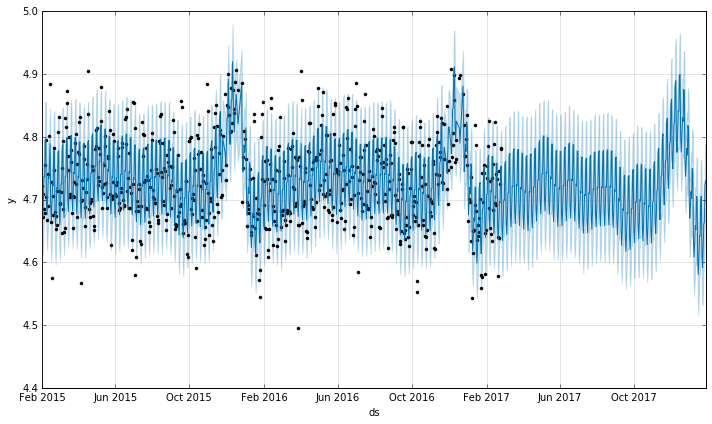

In [18]:
%matplotlib inline
m.plot(forecast);

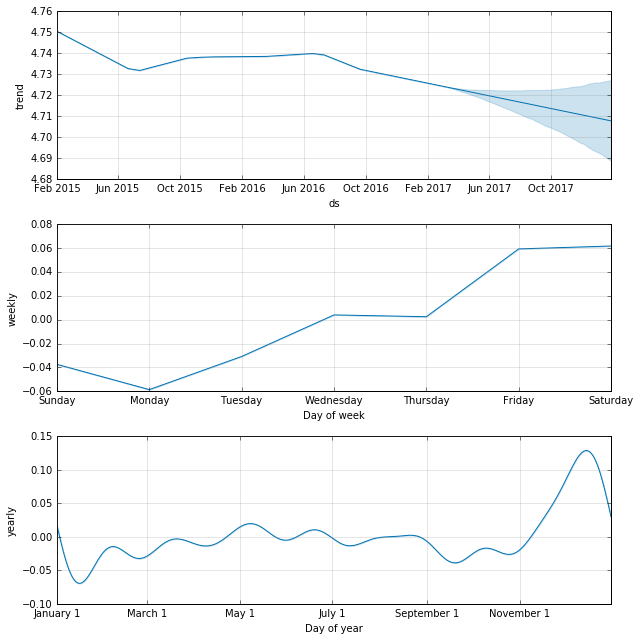

In [19]:
m.plot_components(forecast);

In [20]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1056,2018-01-23,4.707945,4.689375,4.727012,4.564473,4.683815,-0.085418,-0.085418,-0.085418,-0.085418,-0.085418,-0.085418,-0.030828,-0.030828,-0.030828,-0.054590,-0.054590,-0.054590,4.622527
1057,2018-01-24,4.707895,4.689229,4.727059,4.602693,4.723059,-0.046943,-0.046943,-0.046943,-0.046943,-0.046943,-0.046943,0.003878,0.003878,0.003878,-0.050821,-0.050821,-0.050821,4.660952
1058,2018-01-25,4.707845,4.689044,4.727106,4.605625,4.720972,-0.044531,-0.044531,-0.044531,-0.044531,-0.044531,-0.044531,0.002379,0.002379,0.002379,-0.046910,-0.046910,-0.046910,4.663315
1059,2018-01-26,4.707795,4.688879,4.727151,4.663065,4.788053,0.016087,0.016087,0.016087,0.016087,0.016087,0.016087,0.059033,0.059033,0.059033,-0.042945,-0.042945,-0.042945,4.723883
1060,2018-01-27,4.707746,4.688721,4.727194,4.669968,4.788889,0.022425,0.022425,0.022425,0.022425,0.022425,0.022425,0.061438,0.061438,0.061438,-0.039013,-0.039013,-0.039013,4.730171


In [21]:
#Get R-squared to measure model variation
stats.corrcoef(x=txns['y'], y=forecast.loc[:724,'yhat'])

array([[ 1.        ,  0.75357705],
       [ 0.75357705,  1.        ]])

## Additional information to Model
    Scratcher Event & Holidays to consider

In [27]:
#read in dates with Scratcher Event & Holidays listed
dates = pd.read_csv('holiday.csv',parse_dates=['Scratcher Holiday','Ad Changepoint','Year Changepoint','Holidays'])
#set up different event/holiday dataframes, their 'impact' windows and combine sets
scratch_hol = pd.DataFrame({
    'holiday':'holiday',
    'ds': pd.to_datetime(dates['Scratcher Holiday'].dropna()),
    'lower_window':0,
    'upper_window':7,
})
reg_hol = pd.DataFrame({
    'holiday':'holiday',
    'ds': pd.to_datetime(dates['Holidays'].dropna()),
    'lower_window':-2,
    'upper_window':2,
})
new_dates = pd.DataFrame({
    'ds':pd.to_datetime('2017-11-23'), 
    'holiday':'holiday', 
    'lower_window':-2, 
    'upper_window':2,},
    index=[21])
reg_hol = reg_hol.append(new_dates)

holidays = scratch_hol.append(reg_hol)
holidays.head()

,ds,holiday,lower_window,upper_window
0,2016-12-14,holiday,0,7
1,2016-12-02,holiday,0,7
2,2016-11-09,holiday,0,7
3,2016-10-14,holiday,0,7
4,2016-08-12,holiday,0,7


## Forecast fitted with Events

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


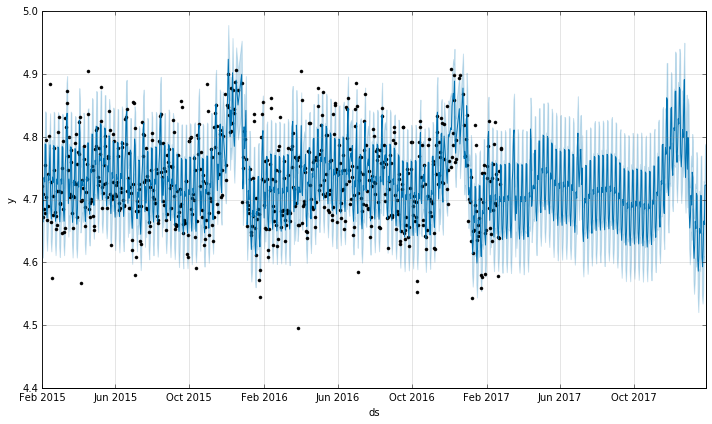

In [28]:
m1 = Prophet(holidays=holidays, holidays_prior_scale=.25)
forecast1 = m1.fit(txns).predict(future)
m1.plot(forecast1);

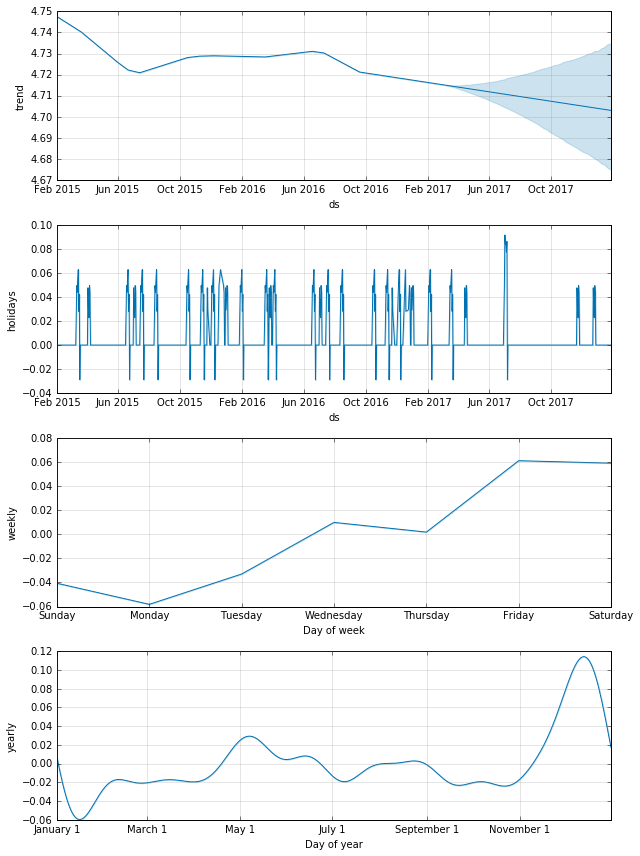

In [29]:
m1.plot_components(forecast1);

In [ ]:
forecast1.to_csv('fcst_daily_txns.csv')
txns.to_csv('data_daily_txns.csv')

In [30]:
#Get R-squared to measure model variation
stats.corrcoef(x=txns['y'], y=forecast1.loc[:724,'yhat'])

array([[ 1.        ,  0.79451865],
       [ 0.79451865,  1.        ]])

## Data by Week

In [32]:
week_data = pd.read_csv('week_data.csv', parse_dates=['ds'])
week_data.describe()

,# Txns,Sales $
count,112.000000,1.120000e+02
mean,387623.285714,2.389304e+07
std,47703.433555,7.113570e+06
min,316991.000000,1.529568e+07
25%,363127.750000,2.034617e+07
50%,375542.500000,2.195671e+07
75%,398826.000000,2.475855e+07
max,596989.000000,5.983885e+07


In [35]:
week_bskt = week_data[['ds','# Txns','Sales $']]
week_bskt['y'] = week_bskt['Sales $']/week_bskt['# Txns']
del week_bskt['Sales $']
del week_bskt['# Txns']
week_bskt.describe()

,y
count,112.000000
mean,60.751429
std,9.758831
min,48.252730
25%,56.113656
50%,58.333813
75%,61.979078
max,119.595904


In [38]:
week_txns = week_data[['ds','# Txns']]
week_txns['y'] = np.log10(week_txns['# Txns'])
del week_txns['# Txns']
week_txns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 2 columns):
ds    112 non-null datetime64[ns]
y     112 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


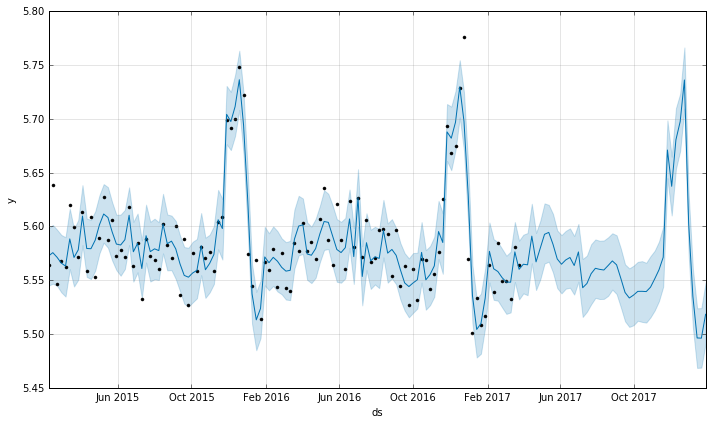

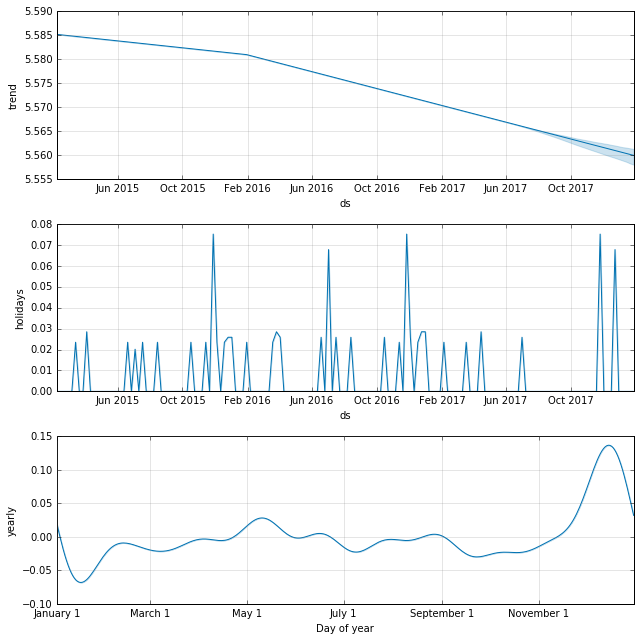

In [39]:
m_week = Prophet(holidays=holidays, changepoints=['2016-01-30','2017-02-04'],changepoint_prior_scale=.25)

m_week.fit(week_txns)

future_week = m_week.make_future_dataframe(periods=44, freq='W-SAT')

fcst_week = m_week.predict(future_week)
m_week.plot(fcst_week);
m_week.plot_components(fcst_week);

In [40]:
fcst_week.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,holiday,holiday_lower,holiday_upper,holidays,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
151,2017-12-30,5.560744,5.559143,5.561825,5.574087,5.630299,0.0,0.0,0.0,0.0,...,0.042402,0.042402,0.042402,0.042402,0.042402,0.042402,0.042402,0.042402,0.042402,5.603146
152,2018-01-06,5.560542,5.558877,5.561655,5.506108,5.560721,0.0,0.0,0.0,0.0,...,-0.025646,-0.025646,-0.025646,-0.025646,-0.025646,-0.025646,-0.025646,-0.025646,-0.025646,5.534896
153,2018-01-13,5.560340,5.558608,5.561560,5.468476,5.523930,0.0,0.0,0.0,0.0,...,-0.063983,-0.063983,-0.063983,-0.063983,-0.063983,-0.063983,-0.063983,-0.063983,-0.063983,5.496357
154,2018-01-20,5.560138,5.558269,5.561413,5.468794,5.524086,0.0,0.0,0.0,0.0,...,-0.063961,-0.063961,-0.063961,-0.063961,-0.063961,-0.063961,-0.063961,-0.063961,-0.063961,5.496177
155,2018-01-27,5.559935,5.557986,5.561291,5.491117,5.547963,0.0,0.0,0.0,0.0,...,-0.041599,-0.041599,-0.041599,-0.041599,-0.041599,-0.041599,-0.041599,-0.041599,-0.041599,5.518336


In [41]:
#Get R-squared to measure model variation
stats.corrcoef(x=week_txns['y'], y=fcst_week.loc[:111,'yhat'])

array([[ 1.        ,  0.89732963],
       [ 0.89732963,  1.        ]])